In [1]:
import itk
import matplotlib.pyplot as plt
import requests
import os

In [2]:
%matplotlib notebook

In [3]:
# Download Etioplast image from Chris Woodcock,
# http://www.cellimagelibrary.org/images/684
filepath = '684.tif'
if not os.path.exists(filepath):
    url = 'http://grackle.crbs.ucsd.edu:8080/OmeroWebService/images/684.tif'
    request = requests.get(url)
    with open(filepath, 'wb') as fp:
        fp.write(request.content)

In [4]:
Dimension = 2
PixelType = itk.ctype('float')
ImageType = itk.Image[PixelType, Dimension]
reader = itk.ImageFileReader[ImageType].New(FileName=filepath)
reader.Update()
image = reader.GetOutput()
print(image)

Image (0x4b99770)
  RTTI typeinfo:   itk::Image<float, 2u>
  Reference Count: 2
  Modified Time: 151
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (0x4bdd2e0) 
  Source output name: Primary
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 18
  UpdateMTime: 152
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 2
    Index: [0, 0]
    Size: [4183, 2804]
  BufferedRegion: 
    Dimension: 2
    Index: [0, 0]
    Size: [4183, 2804]
  RequestedRegion: 
    Dimension: 2
    Index: [0, 0]
    Size: [4183, 2804]
  Spacing: [1, 1]
  Origin: [0, 0]
  Direction: 
1 0
0 1

  IndexToPointMatrix: 
1 0
0 1

  PointToIndexMatrix: 
1 0
0 1

  Inverse Direction: 
1 0
0 1

  PixelContainer: 
    ImportImageContainer (0x4b99920)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, float>
      Reference Count: 1
      Modified Time: 149
      Debug: Off
      Object Name: 
      Observers: 
        none
      Pointer: 0x7f7

<IPython.core.display.Javascript object>


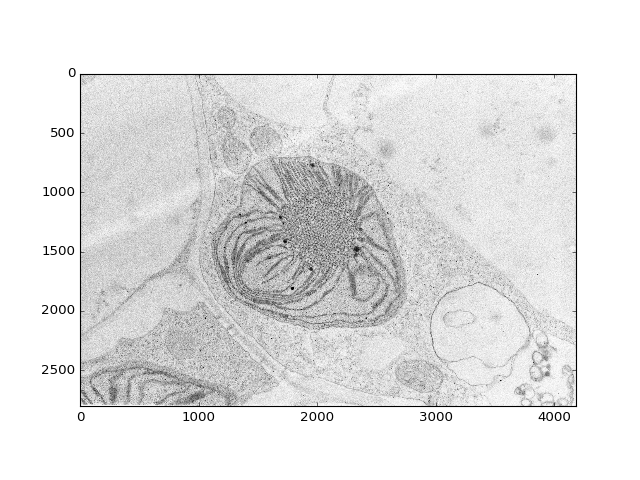

In [5]:
plt.figure(1)
plt.imshow(itk.GetArrayViewFromImage(image), cmap='gray', vmin=20000)

In the center of the figure is an [etioplast, with prolamellar bodies,](http://www.cellimagelibrary.org/images/684#download_options_button) the [lattice of spherical structures at the center of the etioplast](https://www.researchgate.net/publication/226671748_The_Diversity_of_Plastid_Form_and_Function/figures), with thylakoid membranes extending. The dark circular structures are [osmiophilic globules](http://www.cellimagelibrary.org/images/39077).

In [6]:
# Crop to region of interest
roi_filter = itk.RegionOfInterestImageFilter.New(image)
region = itk.ImageRegion[Dimension]()
index = itk.Index[Dimension]()
index[0] = 900
index[1] = 400
region.SetIndex(index)
size = itk.Size[Dimension]()
size[0] = 2200
size[1] = 2000
region.SetSize(size)
roi_filter.SetRegionOfInterest(region)
roi_filter.Update()
roi = roi_filter.GetOutput()

<IPython.core.display.Javascript object>


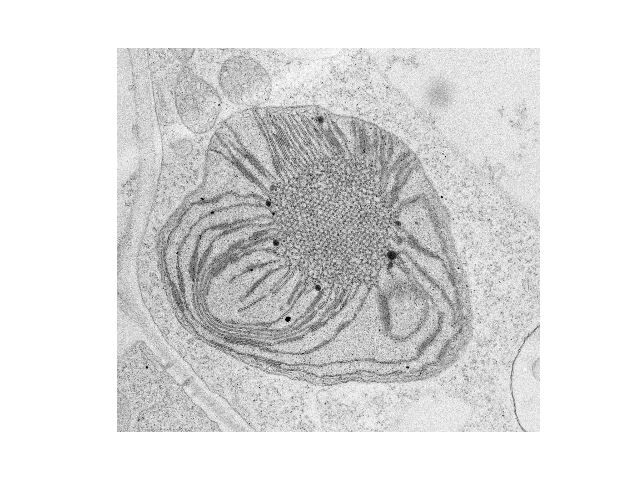

In [7]:
fig, ax = plt.subplots()
ax.imshow(itk.GetArrayViewFromImage(roi), cmap='gray', vmin=20000)
ax.axis('off')
fig.savefig('input.png')

In [8]:
# Crop to small region of interest to experiment with smoothing parameters
small_roi_filter = itk.RegionOfInterestImageFilter.New(roi)
roi_region = itk.ImageRegion[Dimension]()
index = itk.Index[Dimension]()
index[0] = 600
index[1] = 850
roi_region.SetIndex(index)
size = itk.Size[Dimension]()
size[0] = 400
size[1] = 400
roi_region.SetSize(size)
small_roi_filter.SetRegionOfInterest(roi_region)
small_roi_filter.Update()
small_roi = small_roi_filter.GetOutput()

<IPython.core.display.Javascript object>


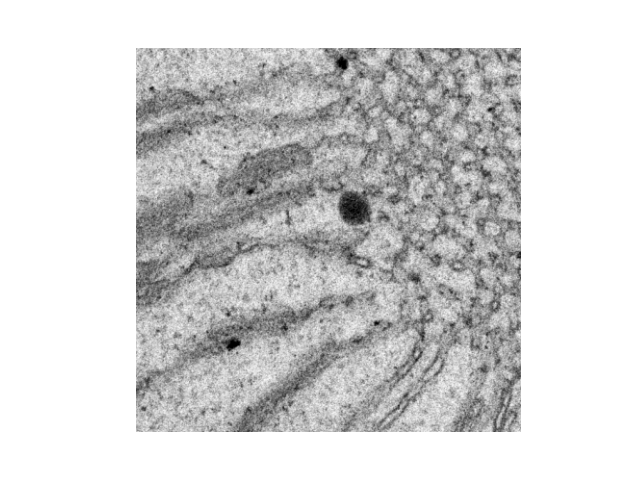

In [9]:
fig, ax = plt.subplots()
ax.imshow(itk.GetArrayViewFromImage(small_roi), cmap='gray', vmin=20000)
ax.axis('off')
fig.savefig('input_roi.png')

In [10]:
smoother = itk.CoherenceEnhancingDiffusionImageFilter.New(roi)
# Determine good parameters here: https://insightsoftwareconsortium.github.io/ITKAnisotropicDiffusionLBR/
smoother.SetDiffusionTime(3.5)
smoother.SetLambda(0.1)
smoother.SetEnhancement(3)
smoother.SetNoiseScale(3)
smoother.SetFeatureScale(5)
smoother.SetExponent(3.5)
smoother.Update()

<IPython.core.display.Javascript object>


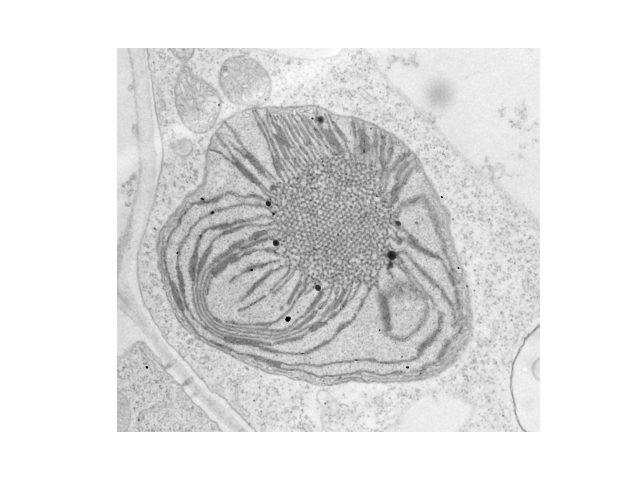

In [11]:
fig, ax = plt.subplots()
ax.imshow(itk.GetArrayViewFromImage(smoother), cmap='gray', vmin=20000)
ax.axis('off')
fig.savefig('filtered.png')

In [12]:
filtered_small_roi_filter = itk.RegionOfInterestImageFilter.New(smoother)
filtered_small_roi_filter.SetRegionOfInterest(roi_region)
filtered_small_roi_filter.Update()
filtered_small_roi = filtered_small_roi_filter.GetOutput()

<IPython.core.display.Javascript object>


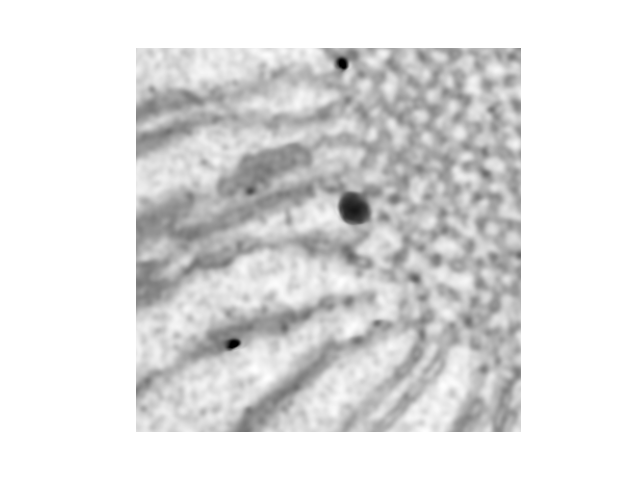

In [13]:
fig, ax = plt.subplots()
ax.imshow(itk.GetArrayViewFromImage(filtered_small_roi), cmap='gray', vmin=20000)
ax.axis('off')
fig.savefig('filtered_roi.png')

<IPython.core.display.Javascript object>


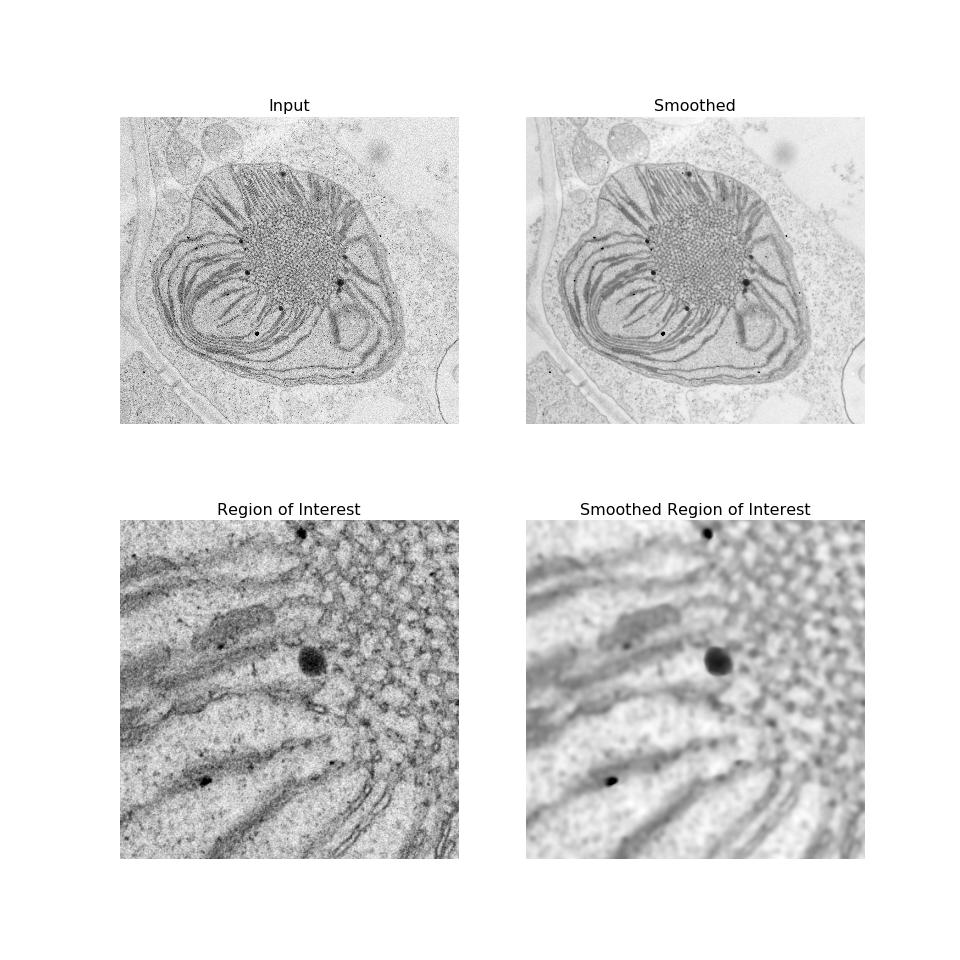

[[<matplotlib.axes._subplots.AxesSubplot object at 0x7f79fbc65210>


In [33]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))
print(axs)
axs[0,0].imshow(itk.GetArrayViewFromImage(roi), cmap='gray', vmin=20000)
axs[0,0].axis('off')
axs[0,0].set_title('Input')
axs[0,1].imshow(itk.GetArrayViewFromImage(smoother), cmap='gray', vmin=20000)
axs[0,1].axis('off')
axs[0,1].set_title('Smoothed')
axs[1,0].imshow(itk.GetArrayViewFromImage(small_roi), cmap='gray', vmin=20000)
axs[1,0].axis('off')
axs[1,0].set_title('Region of Interest')
axs[1,1].imshow(itk.GetArrayViewFromImage(filtered_small_roi), cmap='gray', vmin=20000)
axs[1,1].axis('off')
axs[1,1].set_title('Smoothed Region of Interest')
fig.savefig('comparison_figure.png')

In [ ]:
plt.figure?